# ARL Compare


In [15]:
from exp import *


In [16]:
# pip install --upgrade efficientnet-pytorch


## Load the dataset

In [17]:
dm = DatasetManager('2017',224,'all','2017')

In [18]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.3,p_affine=1, max_warp=0)
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

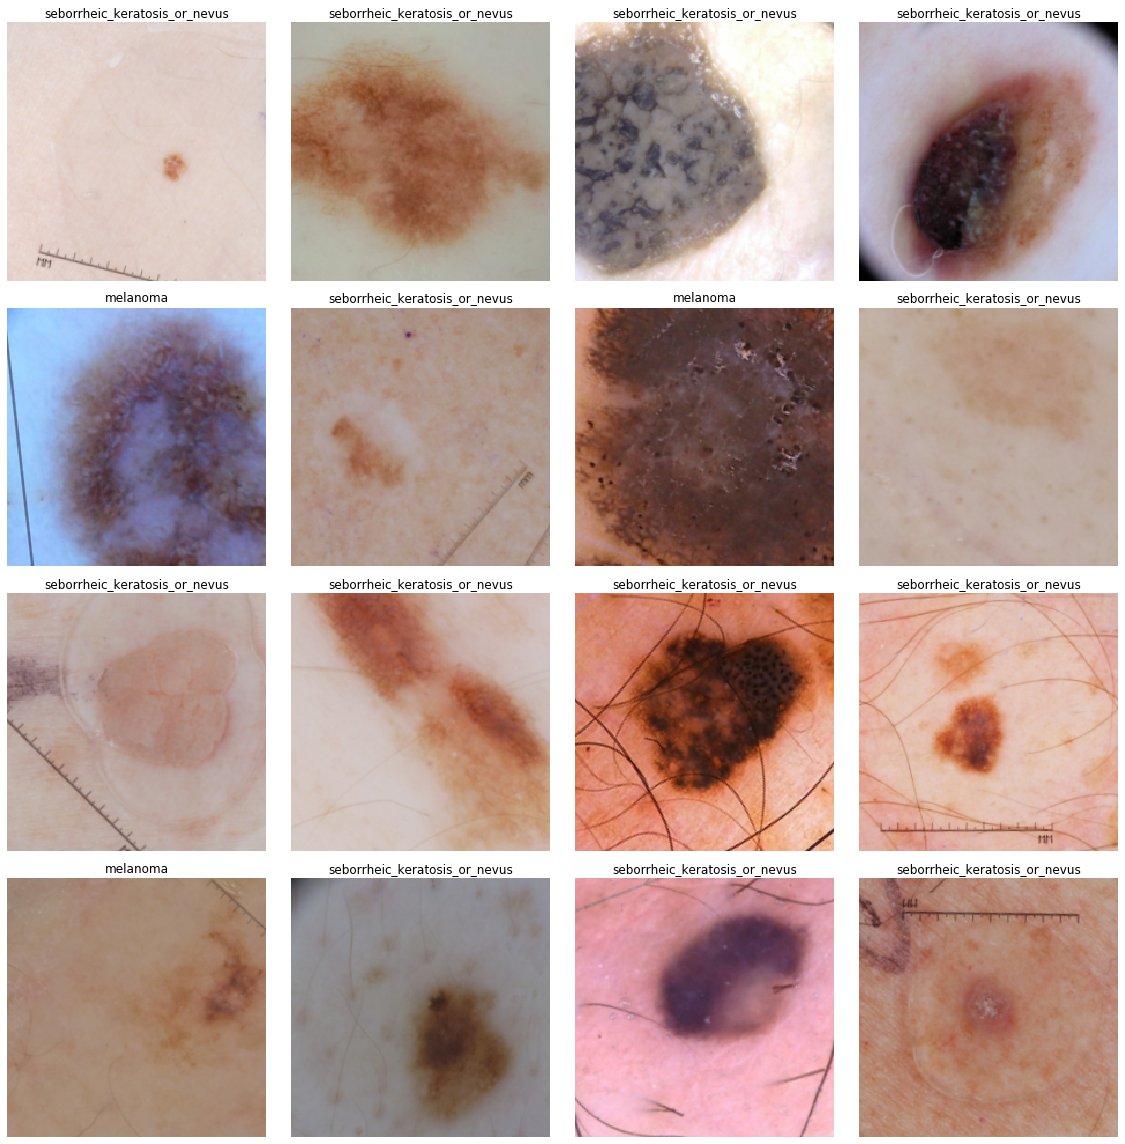

In [19]:
data.show_batch()

In [20]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Adding attention

In [21]:
from torchvision.models.resnet import Bottleneck
import types

In [22]:
alpha_initial_value = 0.0001
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        #identity N x C x H x W
        #alpha C
        #out N x C x H x W
        #out * identity * alpha = N x C x H x W
        
        
        out = out + (identity 
                     * self.softmaxLayer(out.view(*out.size()[:2], -1)).view_as(out) 
                     * self.alpha) + (identity)

        out = self.relu(out)
        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    #apply softmax on the third dimension (indexed by 2 since we count from 0)
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [23]:
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)

In [24]:
bottlenecks = [bn for bn in ResNet50_with_attn.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [25]:
for b in bottlenecks:
    assert b.alpha.requires_grad

## Create the learners

In [27]:
learn_baseline = cnn_learner(data, models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks),OverSamplingCallback ], pretrained=True)

In [28]:
learn_baseline.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [29]:
seed = 1 
random_seed(seed,True)
learn_attn = cnn_learner(data, lambda x: ResNet50_with_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks), OverSamplingCallback], pretrained=True)

In [30]:
ps = list(learn_attn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 16

ps = list(learn_baseline.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 0

# Train Learn attn and visualize alphas

In [30]:
!nvidia-smi

Wed Aug 19 13:23:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 50%   83C    P2   239W / 250W |  11168MiB / 11176MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [27]:
seed =1 
epochs=20
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
arl_acc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.91 GiB total capacity; 144.68 MiB already allocated; 8.06 MiB free; 156.00 MiB reserved in total by PyTorch)

In [26]:
#con oversampling bs = 16
random_seed(seed,True)
learn_attn.fit_one_cycle(4,max_lr=slice(3e-3))

NameError: name 'learn_attn' is not defined

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.040002,0.534214,0.206667,0.793333,0.757222,00:21
1,0.658465,0.415971,0.186667,0.813333,0.810556,00:21
2,0.540416,0.426049,0.200000,0.800000,0.781111,00:21
3,0.495460,0.396961,0.173333,0.826667,0.801389,00:21


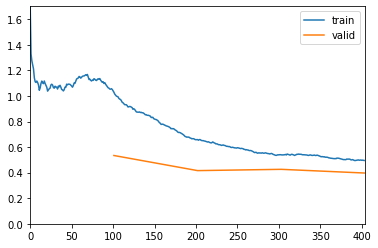

In [18]:
#con oversampling
random_seed(seed,True)
learn_attn.fit_one_cycle(4,max_lr=slice(3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.499225,0.403336,0.186667,0.813333,0.782222,00:30
1,0.474587,0.395015,0.180000,0.820000,0.805833,00:30
2,0.434256,0.390266,0.173333,0.826667,0.813056,00:30
3,0.428055,0.385341,0.166667,0.833333,0.834722,00:30
4,0.422270,0.392399,0.146667,0.853333,0.829167,00:30
5,0.365742,0.469443,0.146667,0.853333,0.820833,00:30
6,0.327367,0.408687,0.173333,0.826667,0.858611,00:30
7,0.286496,0.411685,0.166667,0.833333,0.840278,00:30
8,0.285072,0.393912,0.153333,0.846667,0.859445,00:30
9,0.236898,0.396118,0.106667,0.893333,0.886389,00:30


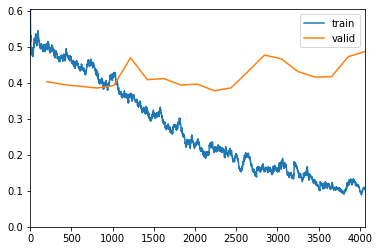

In [32]:
#con oversampling bs = 16
learn_attn.unfreeze()
learn_attn.fit_one_cycle(20,max_lr=slice(3e-4))


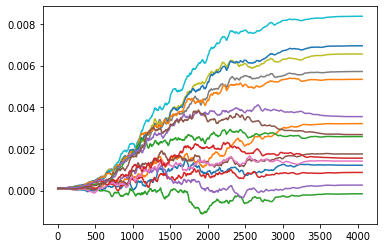

In [35]:
for i in range(len(learn_attn.alphas.stats[0])):
    plt.plot(learn_attn.alphas.stats[0][i])

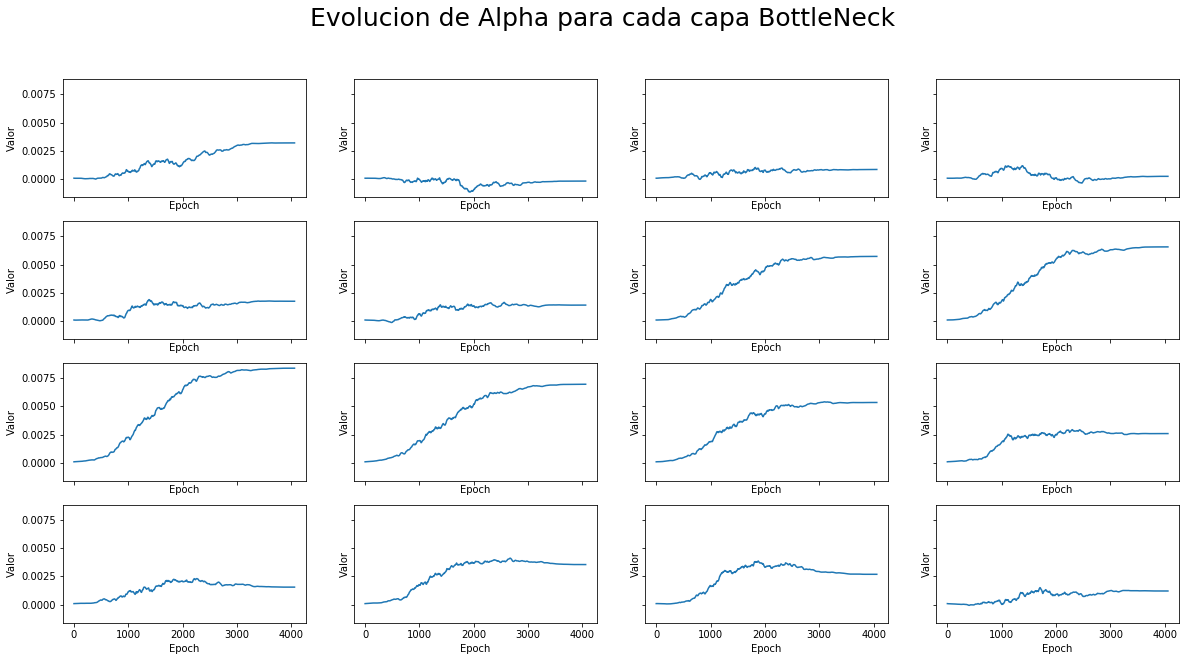

In [36]:
fig,axs = plt.subplots(4,4, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle('Evolucion de Alpha para cada capa BottleNeck', fontsize=25)

for i in range(len(learn_attn.alphas.stats[0])):
    ax = axs[(i-1) // 4, (i-1) % 4]
    ax.plot(learn_attn.alphas.stats[0][i])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Valor')

# Training

In [11]:
def train_model_and_return_metrics(data,model,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, model, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph, OverSamplingCallback], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    
    #Unfreeze
    learner.unfreeze()
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))


    return accuracies

# Comparison Various seeds

In [12]:
results_file_name = 'results/second_take_resnet_50_arl_seed'
columns = ['Baseline','ARL']

In [13]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.933152,0.592143,0.300000,0.700000,0.753611,00:15
1,0.644605,0.527278,0.246667,0.753333,0.683056,00:15
2,0.543904,0.470564,0.186667,0.813333,0.704444,00:16
3,0.523323,0.406186,0.166667,0.833333,0.779722,00:16


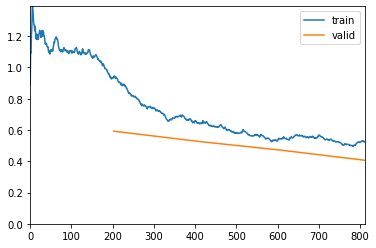

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.501063,0.421832,0.180000,0.820000,0.778889,00:23
1,0.464348,0.399800,0.180000,0.820000,0.810000,00:23
2,0.452880,0.398949,0.173333,0.826667,0.817222,00:23
3,0.427341,0.361151,0.140000,0.860000,0.843611,00:23
4,0.410753,0.383736,0.160000,0.840000,0.855278,00:23
5,0.357560,0.437194,0.166667,0.833333,0.849167,00:23
6,0.297039,0.397624,0.133333,0.866667,0.853333,00:23
7,0.308934,0.523254,0.173333,0.826667,0.830278,00:23
8,0.283315,0.528998,0.180000,0.820000,0.844722,00:23
9,0.221957,0.459598,0.133333,0.866667,0.865278,00:23


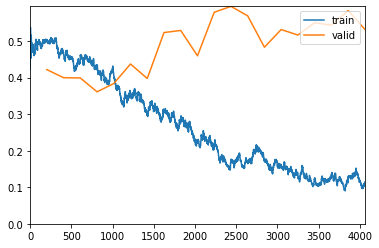

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.929247,0.586368,0.300000,0.700000,0.754722,00:22
1,0.630360,0.531424,0.233333,0.766667,0.709722,00:22
2,0.548271,0.477305,0.180000,0.820000,0.700833,00:22
3,0.526516,0.414273,0.166667,0.833333,0.760833,00:22


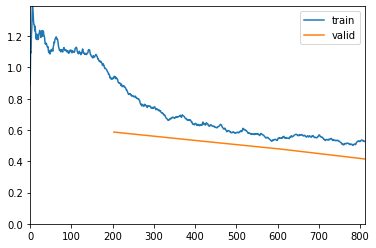

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.499857,0.427244,0.180000,0.820000,0.770556,00:30
1,0.472077,0.416216,0.180000,0.820000,0.786667,00:30
2,0.450141,0.402250,0.186667,0.813333,0.816111,00:30
3,0.426829,0.406545,0.146667,0.853333,0.814166,00:30
4,0.410035,0.385121,0.160000,0.840000,0.834722,00:30
5,0.356476,0.434266,0.153333,0.846667,0.863889,00:30
6,0.316716,0.456245,0.180000,0.820000,0.822778,00:30
7,0.314574,0.474900,0.160000,0.840000,0.837500,00:30
8,0.293062,0.513378,0.180000,0.820000,0.834722,00:30
9,0.220142,0.483845,0.140000,0.860000,0.853889,00:30


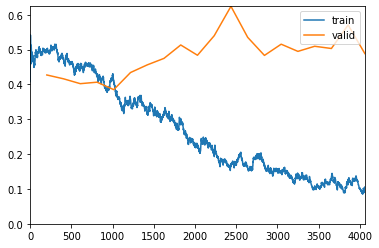

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.909745,0.629041,0.273333,0.726667,0.722778,00:16
1,0.619674,0.432617,0.200000,0.800000,0.836111,00:16
2,0.532145,0.414212,0.206667,0.793333,0.805833,00:16
3,0.493811,0.378703,0.180000,0.820000,0.826111,00:16


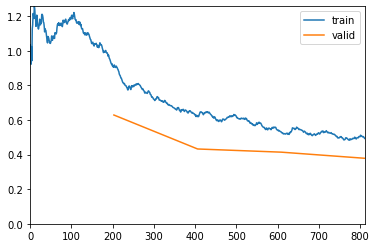

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.513727,0.385282,0.180000,0.820000,0.821944,00:23
1,0.460163,0.390340,0.166667,0.833333,0.817500,00:23
2,0.469332,0.383705,0.160000,0.840000,0.826111,00:23
3,0.415426,0.401885,0.186667,0.813333,0.828889,00:23
4,0.399720,0.423405,0.180000,0.820000,0.832222,00:23
5,0.371713,0.398986,0.160000,0.840000,0.845833,00:23
6,0.344113,0.493865,0.193333,0.806667,0.801944,00:23
7,0.289683,0.494208,0.153333,0.846667,0.846111,00:23
8,0.284847,0.570958,0.153333,0.846667,0.827500,00:23
9,0.249115,0.503189,0.160000,0.840000,0.842778,00:23


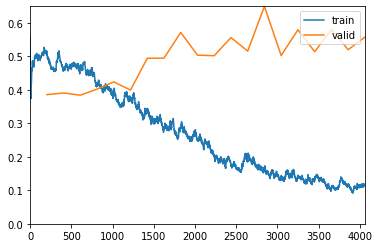

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.899872,0.623029,0.293333,0.706667,0.725556,00:22
1,0.620974,0.404377,0.200000,0.800000,0.844445,00:22
2,0.549562,0.412233,0.186667,0.813333,0.818056,00:22
3,0.485977,0.374352,0.160000,0.840000,0.825833,00:22


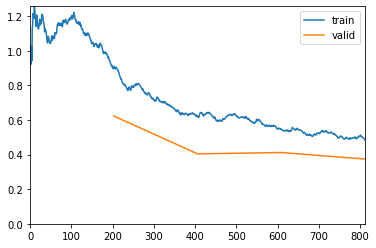

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.516012,0.382137,0.153333,0.846667,0.816667,00:30
1,0.467079,0.375185,0.166667,0.833333,0.829722,00:30
2,0.463295,0.376577,0.146667,0.853333,0.830555,00:30
3,0.413396,0.394802,0.140000,0.860000,0.842222,00:30
4,0.388757,0.442738,0.160000,0.840000,0.817222,00:30
5,0.367019,0.418532,0.173333,0.826667,0.817500,00:30
6,0.339752,0.497798,0.166667,0.833333,0.790556,00:30
7,0.300784,0.384741,0.140000,0.860000,0.880278,00:30
8,0.254486,0.558626,0.166667,0.833333,0.839167,00:30
9,0.238300,0.498952,0.153333,0.846667,0.858611,00:30


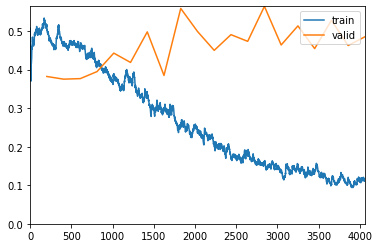

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.905364,0.571694,0.273333,0.726667,0.739445,00:16
1,0.662945,0.497067,0.180000,0.820000,0.719445,00:16
2,0.563533,0.460886,0.206667,0.793333,0.747500,00:16
3,0.504465,0.426970,0.173333,0.826667,0.770556,00:16


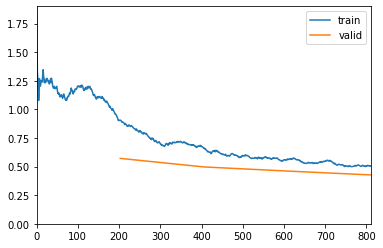

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.489094,0.420589,0.160000,0.840000,0.763889,00:23
1,0.504239,0.422741,0.146667,0.853333,0.778611,00:23
2,0.456587,0.424783,0.186667,0.813333,0.789445,00:23
3,0.417593,0.404845,0.166667,0.833333,0.834722,00:23
4,0.411200,0.402331,0.193333,0.806667,0.833333,00:23
5,0.363207,0.413958,0.186667,0.813333,0.837778,00:23
6,0.328646,0.429667,0.180000,0.820000,0.846944,00:23
7,0.279533,0.522841,0.173333,0.826667,0.811111,00:23
8,0.253260,0.475010,0.180000,0.820000,0.830556,00:23
9,0.231204,0.455970,0.180000,0.820000,0.844444,00:23


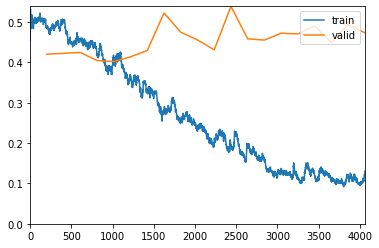

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.914339,0.561315,0.246667,0.753333,0.748333,00:22
1,0.663240,0.516342,0.213333,0.786667,0.715556,00:22
2,0.556821,0.479291,0.200000,0.800000,0.730833,00:22
3,0.517698,0.447711,0.186667,0.813333,0.752500,00:22


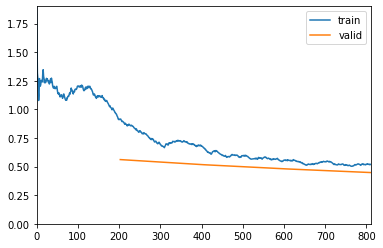

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.489753,0.447370,0.180000,0.820000,0.746667,00:30
1,0.489833,0.433966,0.173333,0.826667,0.775000,00:30
2,0.452422,0.439935,0.226667,0.773333,0.786667,00:30
3,0.420322,0.405456,0.146667,0.853333,0.826667,00:30
4,0.397169,0.408846,0.193333,0.806667,0.846111,00:30
5,0.367690,0.424566,0.146667,0.853333,0.816667,00:30
6,0.340924,0.433949,0.173333,0.826667,0.834444,00:30
7,0.272000,0.588410,0.193333,0.806667,0.793333,00:30
8,0.273827,0.459198,0.153333,0.846667,0.831389,00:30
9,0.251477,0.446925,0.166667,0.833333,0.846111,00:30


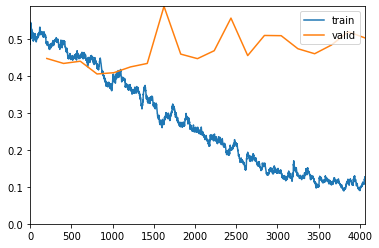

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.908836,0.552763,0.213333,0.786667,0.724167,00:16
1,0.625022,0.534686,0.206667,0.793333,0.678889,00:16
2,0.532655,0.468617,0.180000,0.820000,0.760833,00:16
3,0.512810,0.422462,0.173333,0.826667,0.770556,00:16


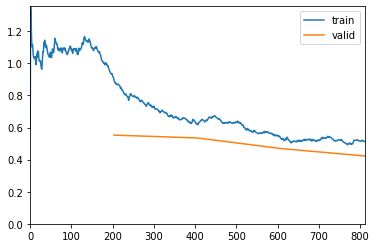

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.515430,0.400106,0.173333,0.826667,0.795000,00:23
1,0.484737,0.379209,0.186667,0.813333,0.826111,00:23
2,0.443657,0.360063,0.153333,0.846667,0.840833,00:23
3,0.417840,0.356682,0.166667,0.833333,0.857222,00:23
4,0.406916,0.370956,0.160000,0.840000,0.863056,00:23
5,0.364505,0.347084,0.133333,0.866667,0.893611,00:23
6,0.312453,0.476917,0.153333,0.846667,0.842500,00:23
7,0.289930,0.581863,0.153333,0.846667,0.820833,00:23
8,0.262779,0.465591,0.146667,0.853333,0.838889,00:23
9,0.218123,0.492072,0.180000,0.820000,0.871389,00:23


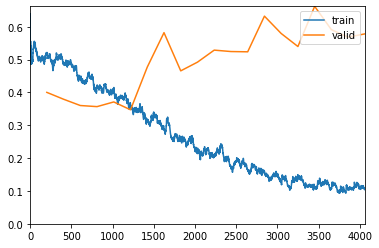

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.910828,0.546958,0.193333,0.806667,0.726945,00:22
1,0.624264,0.548587,0.186667,0.813333,0.661389,00:22
2,0.538472,0.471756,0.180000,0.820000,0.757222,00:22
3,0.505974,0.422864,0.173333,0.826667,0.760278,00:22


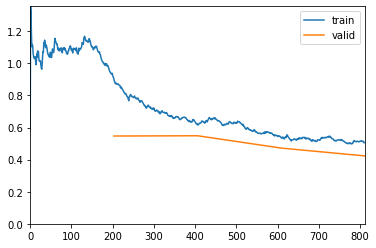

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.516985,0.401059,0.153333,0.846667,0.796667,00:30
1,0.486293,0.390700,0.180000,0.820000,0.808333,00:30
2,0.447108,0.373361,0.166667,0.833333,0.825278,00:30
3,0.420011,0.352496,0.133333,0.866667,0.856389,00:30
4,0.394616,0.445729,0.166667,0.833333,0.826944,00:30
5,0.357140,0.366784,0.153333,0.846667,0.881389,00:30
6,0.296674,0.497299,0.160000,0.840000,0.845556,00:30
7,0.297517,0.585790,0.193333,0.806667,0.794167,00:30
8,0.256809,0.487489,0.186667,0.813333,0.833055,00:30
9,0.240328,0.532976,0.173333,0.826667,0.861389,00:30


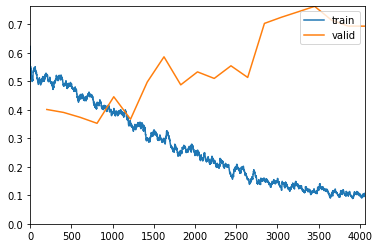

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.913152,0.569574,0.233333,0.766667,0.707500,00:16
1,0.667206,0.468504,0.220000,0.780000,0.742222,00:16
2,0.559841,0.461467,0.193333,0.806667,0.756389,00:16
3,0.516342,0.439348,0.146667,0.853333,0.735556,00:16


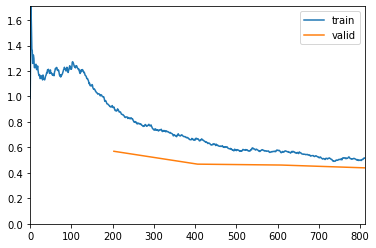

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.454513,0.424928,0.146667,0.853333,0.764722,00:23
1,0.507726,0.430784,0.166667,0.833333,0.753611,00:23
2,0.435678,0.396331,0.153333,0.846667,0.809444,00:23
3,0.411535,0.431538,0.173333,0.826667,0.807778,00:23
4,0.401318,0.427572,0.186667,0.813333,0.828056,00:23
5,0.381413,0.462300,0.166667,0.833333,0.814722,00:23
6,0.327420,0.604944,0.200000,0.800000,0.816667,00:23
7,0.299527,0.385667,0.166667,0.833333,0.887222,00:23
8,0.262913,0.468097,0.146667,0.853333,0.863333,00:23
9,0.203735,0.454493,0.160000,0.840000,0.883055,00:23


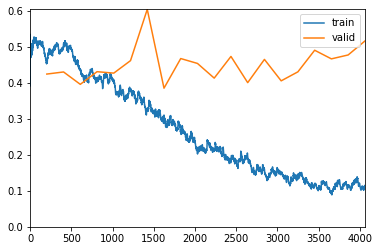

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.918413,0.565641,0.246667,0.753333,0.708889,00:22
1,0.664430,0.472898,0.253333,0.746667,0.735278,00:22
2,0.565608,0.464041,0.200000,0.800000,0.753611,00:22
3,0.513408,0.436002,0.160000,0.840000,0.742222,00:22


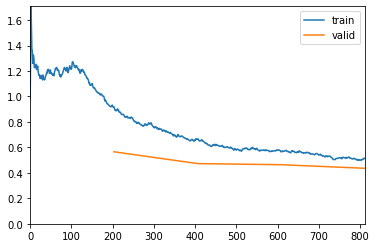

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.465494,0.421277,0.166667,0.833333,0.770278,00:30
1,0.507850,0.430595,0.166667,0.833333,0.755833,00:30
2,0.444074,0.386142,0.146667,0.853333,0.825833,00:30
3,0.416421,0.404172,0.166667,0.833333,0.820278,00:30
4,0.398119,0.421565,0.166667,0.833333,0.811667,00:30
5,0.375901,0.424832,0.153333,0.846667,0.820556,00:30
6,0.330986,0.441218,0.146667,0.853333,0.843889,00:30
7,0.294370,0.437003,0.173333,0.826667,0.853611,00:30
8,0.249658,0.444166,0.186667,0.813333,0.861389,00:30
9,0.217102,0.391105,0.153333,0.846667,0.880834,00:30


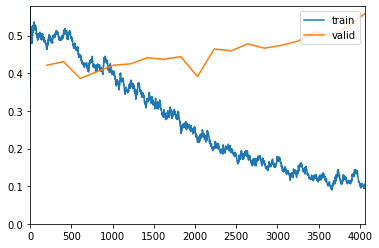

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.956129,0.550388,0.246667,0.753333,0.739444,00:16
1,0.636639,0.473232,0.206667,0.793333,0.734167,00:16
2,0.579027,0.402028,0.166667,0.833333,0.799722,00:16
3,0.488762,0.406004,0.146667,0.853333,0.795278,00:16


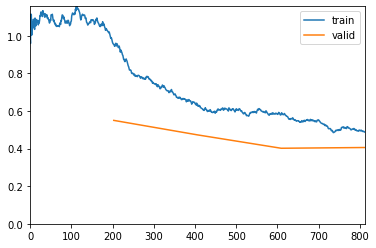

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.516786,0.400973,0.153333,0.846667,0.796111,00:23
1,0.472018,0.409084,0.160000,0.840000,0.802222,00:23
2,0.455427,0.388820,0.140000,0.860000,0.818889,00:23
3,0.416405,0.357755,0.153333,0.846667,0.863889,00:23
4,0.396506,0.376820,0.153333,0.846667,0.859444,00:23
5,0.351603,0.466105,0.180000,0.820000,0.820556,00:23
6,0.336091,0.422696,0.166667,0.833333,0.832500,00:23
7,0.292560,0.386181,0.146667,0.853333,0.864445,00:23
8,0.278808,0.399841,0.166667,0.833333,0.854167,00:23
9,0.222987,0.494989,0.160000,0.840000,0.826389,00:23


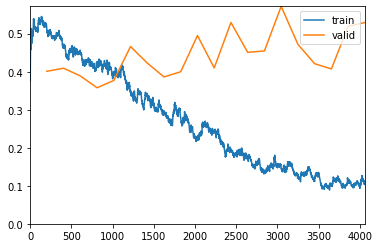

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.961812,0.548132,0.253333,0.746667,0.742778,00:22
1,0.629907,0.468926,0.200000,0.800000,0.747222,00:22
2,0.585479,0.390952,0.166667,0.833333,0.808333,00:22
3,0.499882,0.398585,0.153333,0.846667,0.799167,00:22


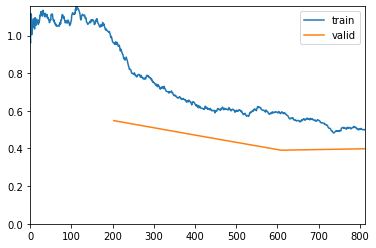

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.520669,0.385611,0.133333,0.866667,0.803333,00:30
1,0.477056,0.400351,0.133333,0.866667,0.801389,00:30
2,0.463460,0.379762,0.133333,0.866667,0.816667,00:30
3,0.409039,0.350529,0.120000,0.880000,0.862500,00:30
4,0.387868,0.387050,0.160000,0.840000,0.858611,00:30
5,0.352326,0.447530,0.173333,0.826667,0.834445,00:30
6,0.316234,0.421187,0.160000,0.840000,0.828333,00:30
7,0.286063,0.427813,0.166667,0.833333,0.826667,00:30
8,0.259725,0.393205,0.166667,0.833333,0.861111,00:30
9,0.232425,0.445568,0.133333,0.866667,0.851945,00:30


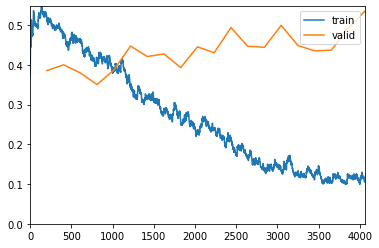

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.899010,0.588825,0.220000,0.780000,0.768333,00:16
1,0.654375,0.522320,0.233333,0.766667,0.770556,00:16
2,0.563304,0.378450,0.146667,0.853333,0.833611,00:16
3,0.480563,0.418545,0.166667,0.833333,0.778611,00:16


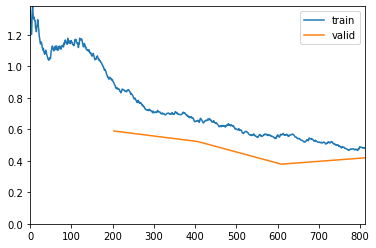

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.488439,0.409036,0.186667,0.813333,0.786944,00:23
1,0.473601,0.396789,0.160000,0.840000,0.804722,00:23
2,0.450159,0.407000,0.186667,0.813333,0.820000,00:23
3,0.410032,0.413291,0.160000,0.840000,0.823055,00:23
4,0.385111,0.380704,0.126667,0.873333,0.855278,00:23
5,0.346094,0.382383,0.133333,0.866667,0.870556,00:23
6,0.300537,0.469599,0.166667,0.833333,0.857778,00:23
7,0.280910,0.383922,0.133333,0.866667,0.884167,00:23
8,0.269710,0.469945,0.180000,0.820000,0.858333,00:23
9,0.230074,0.456819,0.160000,0.840000,0.856945,00:23


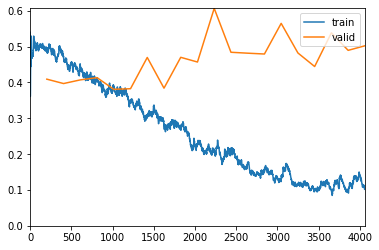

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.900351,0.568556,0.200000,0.800000,0.766389,00:22
1,0.650534,0.515959,0.226667,0.773333,0.774167,00:22
2,0.558420,0.369003,0.133333,0.866667,0.841945,00:22
3,0.491311,0.405623,0.153333,0.846667,0.786389,00:22


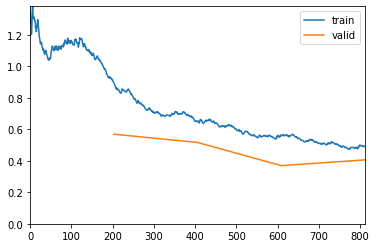

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.492626,0.390784,0.146667,0.853333,0.804722,00:30
1,0.473425,0.366222,0.140000,0.860000,0.826667,00:30
2,0.453141,0.384587,0.186667,0.813333,0.842222,00:30
3,0.416477,0.396747,0.160000,0.840000,0.845556,00:30
4,0.390512,0.374138,0.173333,0.826667,0.860833,00:30
5,0.357738,0.381930,0.146667,0.853333,0.860278,00:30
6,0.293566,0.418192,0.153333,0.846667,0.878056,00:30
7,0.282852,0.440656,0.153333,0.846667,0.875555,00:30
8,0.253167,0.483605,0.160000,0.840000,0.862222,00:30
9,0.226875,0.464789,0.146667,0.853333,0.865833,00:30


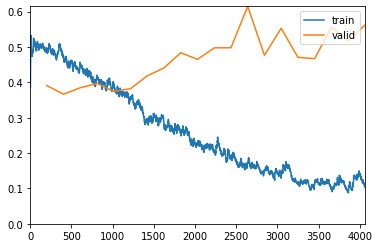

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.957646,0.528214,0.253333,0.746667,0.783056,00:16
1,0.659652,0.471715,0.200000,0.800000,0.733333,00:16
2,0.550920,0.449149,0.173333,0.826667,0.778889,00:16
3,0.499411,0.415764,0.173333,0.826667,0.794722,00:16


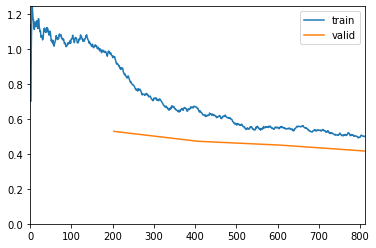

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.497022,0.409893,0.160000,0.840000,0.798889,00:23
1,0.471243,0.375629,0.160000,0.840000,0.841667,00:23
2,0.461881,0.448307,0.193333,0.806667,0.782778,00:23
3,0.395946,0.371157,0.166667,0.833333,0.834444,00:23
4,0.361096,0.369296,0.180000,0.820000,0.853889,00:23
5,0.370106,0.406073,0.166667,0.833333,0.860000,00:23
6,0.320764,0.361221,0.126667,0.873333,0.866944,00:23
7,0.328309,0.439203,0.193333,0.806667,0.849167,00:23
8,0.253192,0.455518,0.166667,0.833333,0.854167,00:23
9,0.260543,0.339686,0.133333,0.866667,0.884167,00:23


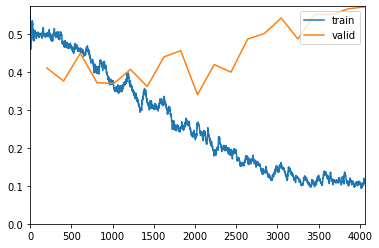

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.955361,0.522392,0.266667,0.733333,0.779445,00:22
1,0.666865,0.473556,0.200000,0.800000,0.733056,00:22
2,0.550167,0.436229,0.193333,0.806667,0.788055,00:22
3,0.503805,0.401159,0.173333,0.826667,0.810833,00:22


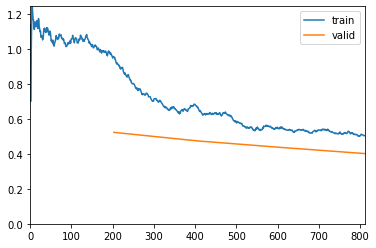

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.494515,0.400763,0.166667,0.833333,0.800556,00:30
1,0.475804,0.377763,0.160000,0.840000,0.830556,00:30
2,0.467941,0.424963,0.166667,0.833333,0.782500,00:30
3,0.397444,0.348320,0.153333,0.846667,0.859444,00:30
4,0.377540,0.334845,0.160000,0.840000,0.874444,00:30
5,0.367218,0.329595,0.153333,0.846667,0.894722,00:30
6,0.330819,0.362115,0.133333,0.866667,0.870556,00:30
7,0.307140,0.383689,0.173333,0.826667,0.854722,00:30
8,0.253494,0.511123,0.180000,0.820000,0.842778,00:30
9,0.240061,0.369451,0.146667,0.853333,0.880556,00:30


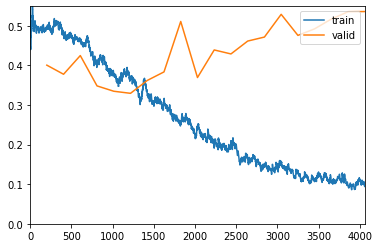

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.942055,0.634658,0.286667,0.713333,0.743333,00:16
1,0.635262,0.485524,0.206667,0.793333,0.744167,00:16
2,0.563268,0.415831,0.186667,0.813333,0.772500,00:16
3,0.505545,0.409164,0.160000,0.840000,0.803333,00:16


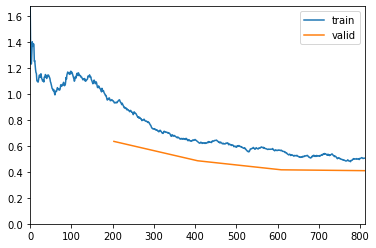

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.508949,0.401340,0.173333,0.826667,0.801945,00:23
1,0.467938,0.387263,0.160000,0.840000,0.818333,00:23
2,0.454454,0.381648,0.160000,0.840000,0.832778,00:23
3,0.439200,0.370494,0.160000,0.840000,0.848611,00:23
4,0.401840,0.372042,0.153333,0.846667,0.863611,00:23
5,0.335844,0.440398,0.166667,0.833333,0.804722,00:23
6,0.334144,0.387508,0.173333,0.826667,0.833611,00:23
7,0.314943,0.469918,0.173333,0.826667,0.828333,00:23
8,0.282578,0.423489,0.173333,0.826667,0.835000,00:23
9,0.232741,0.421901,0.126667,0.873333,0.857222,00:23


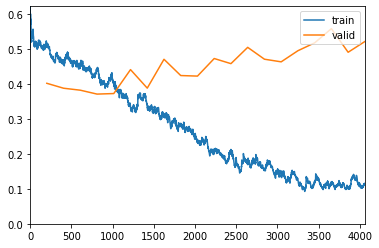

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.943796,0.655259,0.293333,0.706667,0.745556,00:22
1,0.637529,0.469214,0.200000,0.800000,0.744445,00:22
2,0.559125,0.424080,0.180000,0.820000,0.766389,00:22
3,0.508163,0.406742,0.153333,0.846667,0.797222,00:22


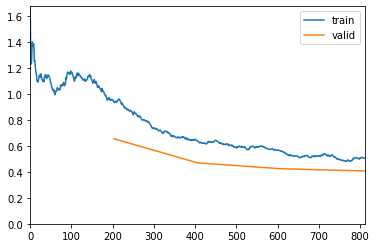

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.496926,0.395991,0.166667,0.833333,0.806389,00:30
1,0.472271,0.384361,0.160000,0.840000,0.822778,00:30
2,0.451054,0.375330,0.146667,0.853333,0.833889,00:30
3,0.441400,0.356588,0.146667,0.853333,0.855556,00:30
4,0.394084,0.358134,0.173333,0.826667,0.870000,00:30
5,0.332845,0.464905,0.160000,0.840000,0.797500,00:30
6,0.335402,0.371083,0.160000,0.840000,0.862778,00:30
7,0.325974,0.461414,0.193333,0.806667,0.849167,00:30
8,0.287918,0.483392,0.173333,0.826667,0.820834,00:30
9,0.230517,0.517158,0.146667,0.853333,0.829444,00:30


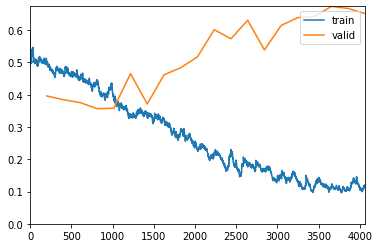

In [14]:
seeds = range(2,11)
epochs = 20

for seed in seeds:
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_acc = train_model_and_return_metrics(data,models.resnet50, seed,epochs)
    
    #ARL
    data = reload_dataset(dm,seed=seed)
    
    ResNet50_with_attn = models.resnet50(pretrained=True)
    apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
    arl_acc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)


    
    write_results(seed, baseline_acc, arl_acc)
    